In [1]:
import tensorflow as tf
from truesight.preprocessing import Preprocessor
from truesight.core import TrueSight
from truesight.metrics import Evaluator, smape, mape, mse, rmse, mae
from truesight.utils import get_input_shapes, generate_syntetic_data

Generate syntetica data for training and testing the model

In [2]:
num_time_steps = 60
seasonal_lenght = 12
forecast_horizon = 12
df = generate_syntetic_data(num_time_steps, seasonal_lenght, 100)

The preprocessor class takes a dataframe with the columns the following columns:

 - unique_id: A string that uniquely identifies each time series in the dataframe
 - ds: A datetime column with the date of each time step. The dates must be in the correct frequency for the date_freq parameter
 - y: The values of the time series

You can include as many statistical models as needed in the model's parameter as long as it follows the statsforecast syntax. However, more models would result in a longer processing time. It is essential to set a fallback_model in case any of the informed models fail to fit.

In [ ]:
from statsforecast.models import SeasonalNaive, AutoETS
from truesight.models import AdditiveDecomposition, TrueSight

preprocessor = Preprocessor(df)
X_train, Y_train, ids_train, X_val, Y_val, ids_val, models = preprocessor.make_dataset(
    forecast_horizon = 12, 
    season_length = 12,
    date_freq = "MS", 
    models = [AdditiveDecomposition, AutoETS, SeasonalNaive], 
    fallback_model = SeasonalNaive,
    verbose = True
    )

Create the model and auto tune the hyperparameters

In [ ]:
input_shapes = get_input_shapes(X_train)
truesight = TrueSight(models, input_shapes, forecast_horizon = forecast_horizon)
truesight.auto_tune(X_train, Y_train, X_val, Y_val, n_trials = 50, batch_size = 512, epochs = 5)

Train the model

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 100, restore_best_weights = True, monitor = "val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 25, verbose = 1),
]
truesight.fit(X_train, Y_train, X_val, Y_val, batch_size = 128, epochs = 1000, verbose = False, callbacks = callbacks)
truesight.plot_history()

Evaluate the results

In [6]:
Y_hat = truesight.predict(X_val, batch_size = 500, n_repeats = 100, n_quantiles = 15, return_quantiles = True, verbose = False)
evaluator = Evaluator(X_val, Y_val, Y_hat, ids_val)
evaluator.evaluate_prediction([smape, mape, mse, rmse, mae], return_mean=True)

smape       0.611742
mape        0.693279
mse      1901.484079
rmse       32.790563
mae        27.048072
dtype: float64

Visualize individual inputs

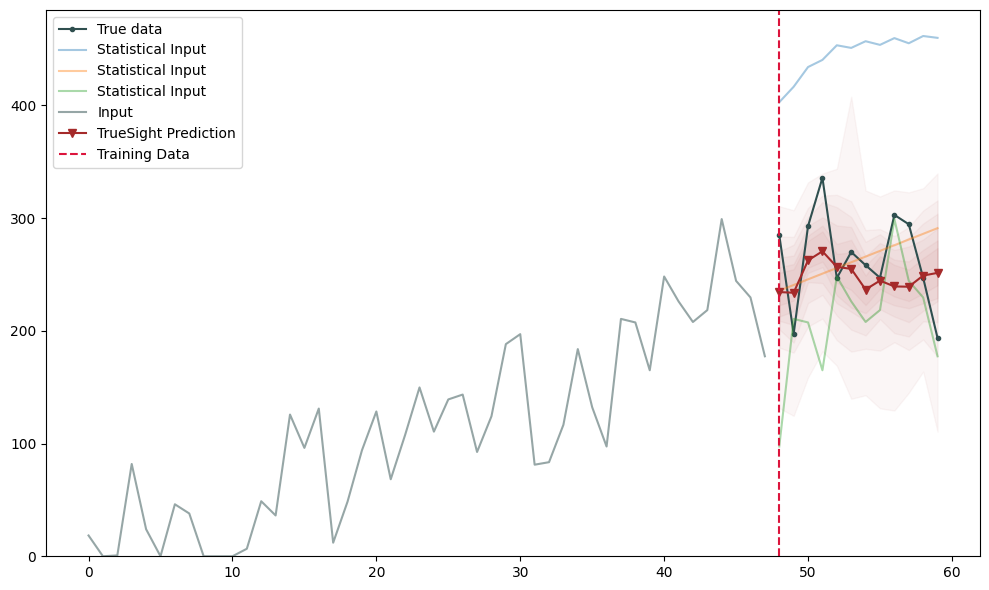

In [26]:
evaluator.plot_exemple()